In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Generate the Dataset

In [3]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../training_data", labels='inferred', label_mode='int',
    class_names=["normal", "abnormal"], color_mode='grayscale', batch_size=batch_size, image_size=image_size, 
    shuffle=True, seed=55, validation_split=0.2, subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../training_data", labels='inferred', label_mode='int',
    class_names=["normal", "abnormal"], color_mode='grayscale', batch_size=batch_size, image_size=image_size, 
    shuffle=True, seed=55, validation_split=0.2, subset="validation"
)

Found 3773 files belonging to 2 classes.
Using 3019 files for training.
Found 3773 files belonging to 2 classes.
Using 754 files for validation.


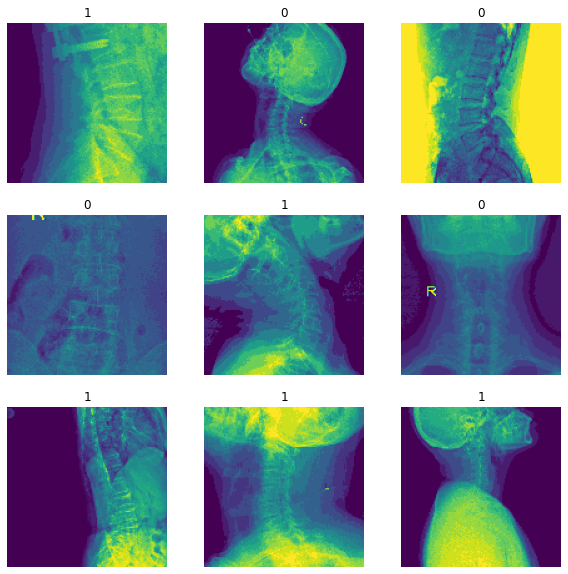

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [8]:
model = make_model(input_shape=image_size + (1,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 1)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['rescaling[0][0]']          

 batch_normalization_7 (BatchNo  (None, 16, 16, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 512)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 8, 8, 512)    131584      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 8, 8, 512)    0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 activatio

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
95/95 [==============================] - 148s 2s/step - loss: 0.7443 - accuracy: 0.5883 - val_loss: 0.7209 - val_accuracy: 0.3462
Epoch 2/50
95/95 [==============================] - 149s 2s/step - loss: 0.6983 - accuracy: 0.6052 - val_loss: 0.7489 - val_accuracy: 0.3462
Epoch 3/50
95/95 [==============================] - 156s 2s/step - loss: 0.6656 - accuracy: 0.6171 - val_loss: 0.7129 - val_accuracy: 0.3462
Epoch 4/50
95/95 [==============================] - 147s 2s/step - loss: 0.6485 - accuracy: 0.6154 - val_loss: 0.8140 - val_accuracy: 0.3462
Epoch 5/50
95/95 [==============================] - 146s 2s/step - loss: 0.6301 - accuracy: 0.6270 - val_loss: 0.7111 - val_accuracy: 0.3607
Epoch 6/50
95/95 [==============================] - 147s 2s/step - loss: 0.6171 - accuracy: 0.6168 - val_loss: 0.7299 - val_accuracy: 0.3700
Epoch 7/50
95/95 [==============================] - 161s 2s/step - loss: 0.6128 - accuracy: 0.6346 - val_loss: 0.7066 - val_accuracy: 0.4721
Epoch 8/50
95

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
model = keras.models.load_model('./save_at_11.h5')

In [ ]:
train_labels = []
train_predictions = []
for train_image, train_label in train_ds:
    train_prediction = model.predict(train_image)
    for val in train_label:
        train_labels.append(val)
    for val in train_prediction:
        train_predictions.append(val)

In [ ]:
val_labels = []
val_predictions = []
for val_image, val_label in val_ds:
    val_prediction = model.predict(val_image)
    for val in val_label:
        val_labels.append(val)
    for val in val_prediction:
        val_predictions.append(val)

In [ ]:
print("train:")
roc_auc_score(train_labels, train_predictions)

In [ ]:
print("val:")
roc_auc_score(val_labels, val_predictions)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
targets_val = []
for pred in val_predictions:
    if pred > 0.5:
        targets_val.append(1)
    else:
        targets_val.append(0)

In [ ]:
f1_score(val_labels, targets_val)